In [114]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl
    
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '/home/dhruv/codebase/pyLDLE2/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
import numpy as np
from pyLDLE2 import util_, visualize_, datasets, buml_
from scipy.sparse import coo_matrix
from scipy import optimize
from scipy.special import erf, erfinv
from matplotlib import pyplot as plt
from scipy.stats import chi2
from scipy.sparse.linalg import svds
import bx_util
from joblib import Parallel, delayed
from matplotlib import cm
import colorblind

from umap import UMAP

In [3]:
vis = visualize_.Visualize()

In [4]:
ex_name = '../figures/final_figures/mnist'

In [5]:
digits=np.arange(10).tolist()

In [6]:
X, labelsMat, imgs, img_shape = datasets.Datasets().mnist(n=5000, digits=digits, n_pca=None)

X_new.shape =  (50000, 784)


In [7]:
X = X/255

In [8]:
labels = labelsMat[:,0].astype(int)

In [9]:
umap_obj = UMAP(n_components=2, n_neighbors=10, min_dist=0.25, random_state=42)
y = umap_obj.fit_transform(X)

/home/dhruv/anaconda3/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [10]:
rep_coord = {}
for i in digits:
    mask = labels==i
    rep_coord[i] = np.median(y[mask,:], axis=0)

In [11]:
def annotate():
    for i in digits:
        plt.annotate(str(i), (rep_coord[i][0], rep_coord[i][1]), fontsize=12)

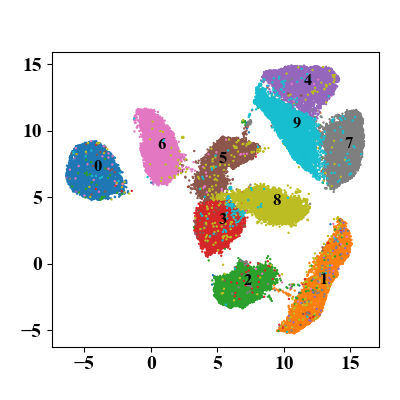

In [12]:
vis.data(y, labels, cmap='tab10', figsize=(4,4), s=2, title=None)
annotate()
plt.tight_layout()
plt.savefig(ex_name + '_umap.pdf', dpi=400)

In [13]:
max_prctile = 10
k_nn = 512
k_tune = 128

In [14]:
def estimate_bx_parallel(data, opts, method='ds'):
    def process(i):
        mask = labels==i
        if method=='ds':
            bx_ds, bx_init_ds, W_ds, D_ds, nu_norm_ds = bx_util.estimate_bx(data[mask,:], opts=opts)
            return (bx_ds, nu_norm_ds)
        else:
            bx, bx_init, nu_norm = bx_util.estimate_bx_berry_and_sauer(data[mask,:], opts=opts)
            return (bx, nu_norm)
    
    results = Parallel(n_jobs=len(digits))(delayed(process)(i) for i in digits)
    bx_per_digit = []
    nu_norm_per_digit = []
    for res in results:
        bx_per_digit.append(res[0])
        nu_norm_per_digit.append(res[1])
    return bx_per_digit, nu_norm_per_digit

In [172]:
def plot_bx(bx_per_digit, prctile=None, save_fn=None, lt=True, figsize=(6,6), s=1):
    plt.figure(figsize=figsize)
    colors = colorblind.rainbow_colormap(np.linspace(0,1,len(digits)))
    for i in digits:
        mask = labels==i
        bx = bx_per_digit[i].copy()
        bx = bx/np.max(bx)
        plt.scatter(*y[mask,:].T, s=s, alpha=0.3, label=i, color=colors[i,:])
        if prctile:
            if lt:
                mask2 = bx < np.percentile(bx, prctile)
            else:
                mask2 = bx > np.percentile(bx, prctile)
            #plt.scatter(*y[mask,:][mask2,:].T,  s=1)
            #plt.scatter(*y[mask,:][~mask2,:].T,  s=1)
            plt.scatter(*y[mask,:][mask2,:].T, color='k', s=s)
        else:
            plt.scatter(*y[mask,:].T, c=bx, s=0.5, cmap='jet')

    plt.axis('image')
    leg = plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', markerscale=15)
    for lh in leg.legend_handles: 
        lh.set_alpha(1)
    plt.tight_layout()
    if save_fn:
        plt.savefig(ex_name+'_'+save_fn+'.png', dpi=400)
    plt.show()

def plot_bx_percentile_wise(bx_per_digit, dprctile=10, save_fn=None, lt=True, figsize=(5,5), s=0.5):
    plt.figure(figsize=figsize)
    cur_prctile = dprctile
    n_levels = int(np.ceil(100/dprctile))
    colors = cm.nipy_spectral(np.linspace(0,1,n_levels))
    is_visited = {}
    for i in digits:
        is_visited[i] = np.zeros(len(bx_per_digit[i]), dtype=bool)
    ctr = 0
    for j in range(n_levels):
        for i in digits:
            mask = labels==i
            bx = bx_per_digit[i].copy()
            bx = bx/np.max(bx)
            #plt.scatter(*y[mask,:].T, s=1)
            if lt:
                mask2 = bx < np.percentile(bx, cur_prctile)
            else:
                mask2 = bx > np.percentile(bx, cur_prctile)
            mask2 = mask2 & ~is_visited[i]
            is_visited[i][mask2] = 1
            #plt.scatter(*y[mask,:][mask2,:].T,  s=1)
            #plt.scatter(*y[mask,:][~mask2,:].T,  s=1)
            plt.scatter(*y[mask,:][mask2,:].T, s=s, color=colors[j,:])
        cur_prctile += dprctile
        if cur_prctile > 100:
            cur_prctile = 100

    plt.axis('image')
    plt.tight_layout()
    if save_fn:
        plt.savefig(ex_name+'_'+save_fn+'.png', dpi=400)
    plt.show()

In [190]:
def compare_bdry(bx_per_digit1, bx_per_digit2, prctile=10, save_fn=None, lt=True, figsize=(5,5), s=1, alpha=0.2):
    plt.figure(figsize=figsize)
    for i in digits:
        mask = labels==i
        bx1 = bx_per_digit1[i].copy()
        bx2 = bx_per_digit2[i].copy()
        plt.scatter(*y[mask,:].T, s=s, alpha=0.3, label=i)
        if lt:
            mask1 = bx1 < np.percentile(bx1, prctile)
            mask2 = bx2 < np.percentile(bx2, prctile)
        else:
            mask1 = bx1 > np.percentile(bx1, prctile)
            mask2 = bx2 > np.percentile(bx2, prctile)
        #plt.scatter(*y[mask,:][mask2,:].T,  s=1)
        #plt.scatter(*y[mask,:][~mask2,:].T,  s=1)
        plt.scatter(*y[mask,:][mask1,:].T, color='r',  s=s)
        plt.scatter(*y[mask,:][mask2,:].T, color='b',  s=s)

    plt.axis('image')
    plt.tight_layout()
    if save_fn:
        plt.savefig(ex_name+'_'+save_fn+'.png', dpi=400)
    plt.show()
    
def compare_bdry_diff(bx_per_digit1, bx_per_digit2, prctile=10,
                      save_fn=None, lt=True, figsize=(5,5), s=1,
                      plot=-1, alpha=0.3):
    plt.figure(figsize=figsize)
    colors = colorblind.rainbow_colormap(np.linspace(0,1,10))
    jac_ind = []
    for i in digits:
        mask = labels==i
        bx1 = bx_per_digit1[i].copy()
        bx2 = bx_per_digit2[i].copy()
        #plt.scatter(*y[mask,:].T, s=s, alpha=0.05, color='#faf0cf')
        plt.scatter(*y[mask,:].T, s=2, alpha=0.05, label=i, color=colors[i,:])
        if lt:
            mask1 = bx1 < np.percentile(bx1, prctile)
            mask2 = bx2 < np.percentile(bx2, prctile)
        else:
            mask1 = bx1 > np.percentile(bx1, prctile)
            mask2 = bx2 > np.percentile(bx2, prctile)

        jac_ind_i = np.sum(mask1*mask2)/np.sum(mask1+mask2)
        print('digit:', i, 'Jaccard index:', jac_ind_i)
        jac_ind.append(jac_ind_i)
        #plt.scatter(*y[mask,:][mask2,:].T,  s=1)
        #plt.scatter(*y[mask,:][~mask2,:].T,  s=1)
        if plot==1 or plot==-1:
            plt.scatter(*y[mask,:][mask1 & mask2,:].T, color='k', s=s, alpha=3*alpha)
        if plot==2 or plot==-1:
            plt.scatter(*y[mask,:][mask1 & (~mask2),:].T, color='k', s=2*s, alpha=3*alpha)
        if plot==3 or plot==-1:
            plt.scatter(*y[mask,:][(~mask1) & mask2,:].T, color='k',  s=2*s, alpha=3*alpha)

    print('Avg Jaccard index:', np.mean(jac_ind))
    plt.axis('image')
    leg = plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', markerscale=15)
    for lh in leg.legend_handles: 
        lh.set_alpha(1)
    plt.tight_layout()
    if save_fn:
        plt.savefig(ex_name+'_'+save_fn+'.png', dpi=400)
    plt.show()

In [151]:
opts = bx_util.default_opts.copy()
opts['local_subspace'] = None
opts['d'] = 2
opts['k_nn'] = k_nn
opts['k_tune'] = k_tune
bx_ds_per_digit, nu_norm_ds_per_digit = estimate_bx_parallel(X, opts)

matplotlib.get_backend() =  module://matplotlib_inline.backend_inline
0.002239564765134689
0.0007774688083997091
0.00035042079264186035
0.00017668900653734684
0.00010000334942918147
5.816156068681881e-05
3.587624408214384e-05
2.4092800436836627e-05
1.4140000256846963e-05
9.419145248317454e-06
6.5383090135150885e-06
4.2782673591112705e-06
2.678372348918097e-06
7.136452596111606e-07
h_per_point min max median 0.024742986179358627 0.024747339667261385 0.024743282489324954
Error: 0.08808215794221441
matplotlib.get_backend() =  module://matplotlib_inline.backend_inline
0.002399264733473403
0.0006798309256424344
0.0003155703810931966
0.00019506929622288257
0.0001325010238217172
9.364993042142111e-05
6.741844577561865e-05
5.016909151771305e-05
3.8105986005361264e-05
2.9250109170700067e-05
2.258394240489531e-05
1.605782941859312e-05
1.0021565450627674e-05
5.861384758158158e-06
3.563560392315639e-06
1.4692596323278102e-06
5.864701256702417e-07
h_per_point min max median 0.01951108041877857 0.01

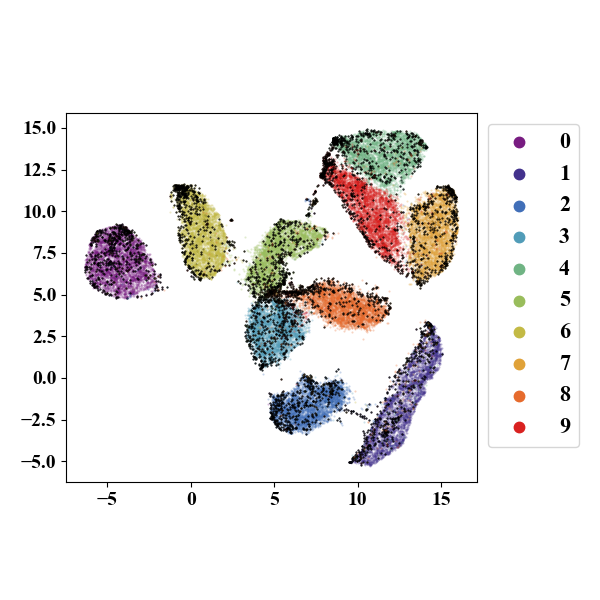

In [174]:
plot_bx(bx_ds_per_digit, max_prctile)

In [17]:
opts = bx_util.default_opts.copy()
opts['k_nn'] = k_nn
opts['k_tune'] = k_tune
opts['local_subspace'] = 'local_pca'
opts['d'] = 2
bx_ds_lpca_per_digit, nu_norm_ds_lpca_per_digit = estimate_bx_parallel(X, opts)

matplotlib.get_backend() =  module://matplotlib_inline.backend_inline
0.0019875292052808765
0.0006096313424166018
0.0002771011296903163
0.00015904766030061762
0.00010386711477397972
6.972818261770783e-05
5.0461140266719453e-05
3.574988160937747e-05
2.7845260076108414e-05
2.3164589932746747e-05
1.9788415469689425e-05
1.516849686410199e-05
1.2692995219234072e-05
1.0156473544843944e-05
6.73294770297988e-06
5.069038871369694e-06
3.773163090429262e-06
2.7974983167575928e-06
1.940345819756269e-06
8.144346126978133e-07
h_per_point min max median 0.022818177636925972 0.022824665040597956 0.02281983075272863
Error: 0.0787525783137466
Error: 0.008722196043541963
matplotlib.get_backend() =  module://matplotlib_inline.backend_inline
0.002239564765134689
0.0007774688083997091
0.00035042079264186035
0.00017668900653734684
0.00010000334942918147
5.816156068681881e-05
3.587624408214384e-05
2.4092800436836627e-05
1.4140000256846963e-05
9.419145248317454e-06
6.5383090135150885e-06
4.2782673591112705e-06

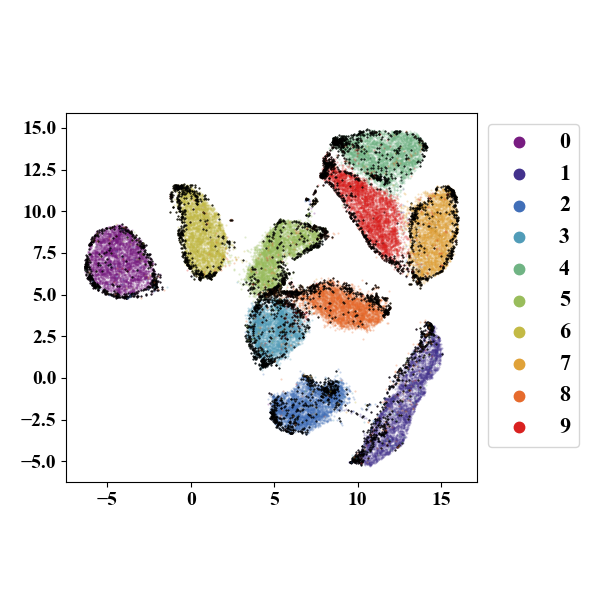

In [175]:
plot_bx(bx_ds_lpca_per_digit, max_prctile)

In [22]:
opts = bx_util.default_opts.copy()
opts['k_nn'] = k_nn
opts['k_tune'] = k_tune
opts['local_subspace'] = 'local_pca'
opts['d'] = 2
bx_bs_lpca_per_digit, nu_norm_bs_lpca_per_digit = estimate_bx_parallel(X, opts, method='bs')

matplotlib.get_backend() =  module://matplotlib_inline.backend_inline
0.0018596777138052947
0.0003913935090296715
0.000187228567565044
0.0001282334512029788
9.92532400103348e-05
8.123319590073114e-05
6.607521270238028e-05
5.712215068972688e-05
5.021299738296503e-05
4.297845824666506e-05
3.7108074586640274e-05
3.139252707039197e-05
2.6976965823936382e-05
2.2380956514673544e-05
1.819057068260768e-05
1.4664867908009139e-05
1.1950232890752142e-05
1.0075018939014596e-05
8.004918759379636e-06
6.708722383196257e-06
5.369608867987275e-06
4.616041744246808e-06
3.97258378907058e-06
3.737597547425873e-06
3.0183279081877186e-06
2.373078139901838e-06
1.3942700285961605e-06
1.0878862089910804e-06
7.232956638440646e-07
h_per_point min max median 0.024163579761777333 0.024169573948031754 0.02416486190865136
Error at iter: 0 is: 0.0213681159499453
newton method converged at iter: 4
matplotlib.get_backend() =  module://matplotlib_inline.backend_inline
0.002161858259281062
0.000649202525744469
0.00029073

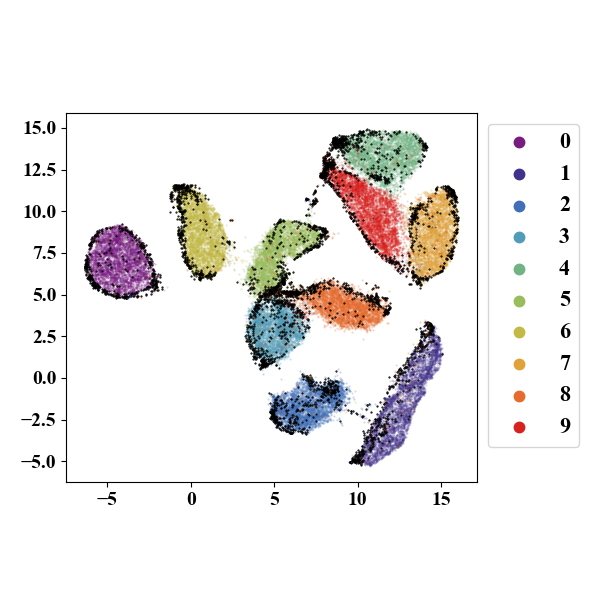

In [176]:
plot_bx(bx_bs_lpca_per_digit, max_prctile)

In [162]:
opts = bx_util.default_opts.copy()
opts['k_nn'] = k_nn
opts['k_tune'] = k_tune
opts['local_subspace'] = None
opts['d'] = 2
bx_bs_per_digit, nu_norm_bs_per_digit = estimate_bx_parallel(X, opts, method='bs')

matplotlib.get_backend() =  module://matplotlib_inline.backend_inline
0.001774535717209626
0.00031240760143174014
0.00012608873407919178
6.617109828355248e-05
4.2805222612376626e-05
3.140980638736382e-05
2.1840601542324572e-05
1.8201520938116575e-05
1.4315847597459392e-05
1.2943412013089878e-05
1.1936435246416147e-05
1.1995912057892413e-05
1.1084588704669632e-05
1.120064372205444e-05
1.1858062501985926e-05
9.891763866252077e-06
8.2671091344827e-06
8.220774277030668e-06
8.036338714651522e-06
7.316588117107692e-06
5.829512157633444e-06
4.810358584303867e-06
4.347856913392811e-06
3.930191841861024e-06
3.408732749288791e-06
3.1044978470956393e-06
2.3353054560617146e-06
2.1043668169280746e-06
1.93427457151262e-06
1.9492773704440363e-06
h_per_point min max median 0.011136515459640395 0.011704393426843146 0.011228631557958224
Error at iter: 0 is: 0.009302388013800011
newton method converged at iter: 4
matplotlib.get_backend() =  module://matplotlib_inline.backend_inline
0.002239564765134689
0

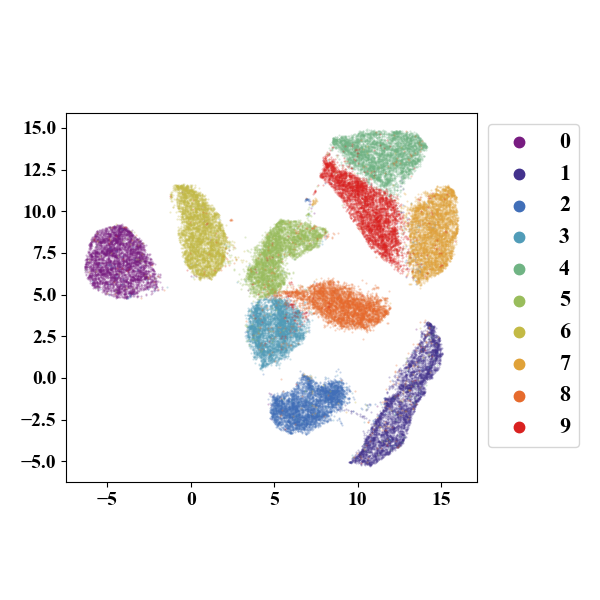

In [177]:
plot_bx(bx_bs_per_digit, max_prctile)

digit: 0 Jaccard index: 0.9193857965451055
digit: 1 Jaccard index: 0.8315018315018315
digit: 2 Jaccard index: 0.8552875695732839
digit: 3 Jaccard index: 0.8518518518518519
digit: 4 Jaccard index: 0.8148820326678766
digit: 5 Jaccard index: 0.8552875695732839
digit: 6 Jaccard index: 0.8148820326678766
digit: 7 Jaccard index: 0.8484288354898336
digit: 8 Jaccard index: 0.8315018315018315
digit: 9 Jaccard index: 0.8518518518518519
Avg Jaccard index: 0.8474861203224627


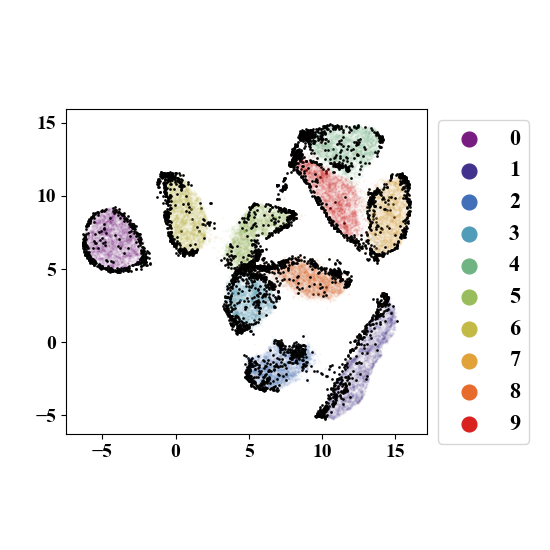

digit: 0 Jaccard index: 0.9193857965451055
digit: 1 Jaccard index: 0.8315018315018315
digit: 2 Jaccard index: 0.8552875695732839
digit: 3 Jaccard index: 0.8518518518518519
digit: 4 Jaccard index: 0.8148820326678766
digit: 5 Jaccard index: 0.8552875695732839
digit: 6 Jaccard index: 0.8148820326678766
digit: 7 Jaccard index: 0.8484288354898336
digit: 8 Jaccard index: 0.8315018315018315
digit: 9 Jaccard index: 0.8518518518518519
Avg Jaccard index: 0.8474861203224627


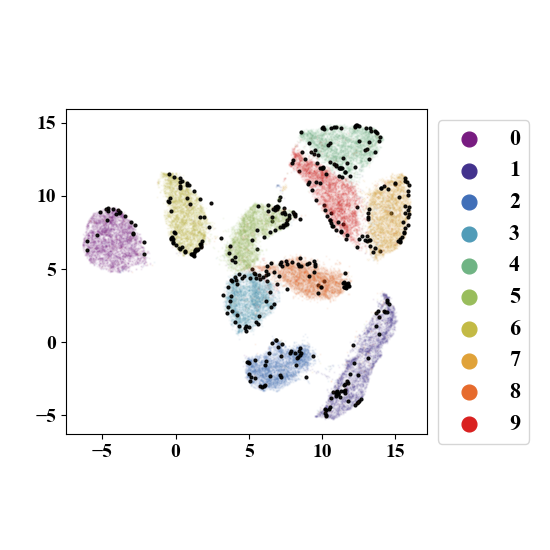

digit: 0 Jaccard index: 0.9193857965451055
digit: 1 Jaccard index: 0.8315018315018315
digit: 2 Jaccard index: 0.8552875695732839
digit: 3 Jaccard index: 0.8518518518518519
digit: 4 Jaccard index: 0.8148820326678766
digit: 5 Jaccard index: 0.8552875695732839
digit: 6 Jaccard index: 0.8148820326678766
digit: 7 Jaccard index: 0.8484288354898336
digit: 8 Jaccard index: 0.8315018315018315
digit: 9 Jaccard index: 0.8518518518518519
Avg Jaccard index: 0.8474861203224627


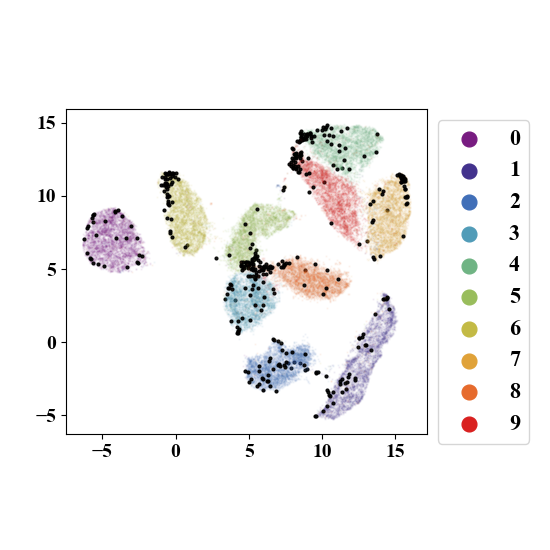

In [191]:
compare_bdry_diff(bx_ds_lpca_per_digit, bx_bs_lpca_per_digit, 10, s=4, plot=1, figsize=(5.5,5.5), save_fn='DS_LPCA_cap_Standard_LPCA')
compare_bdry_diff(bx_ds_lpca_per_digit, bx_bs_lpca_per_digit, 10, s=8, plot=2, figsize=(5.5,5.5), save_fn='DS_LPCA_minus_Standard_LPCA')
compare_bdry_diff(bx_ds_lpca_per_digit, bx_bs_lpca_per_digit, 10, s=8, plot=3, figsize=(5.5,5.5), save_fn='Standard_LPCA_minus_DS_LPCA')

digit: 0 Jaccard index: 0.12866817155756208
digit: 1 Jaccard index: 0.2610340479192938
digit: 2 Jaccard index: 0.19189511323003575
digit: 3 Jaccard index: 0.23915737298636927
digit: 4 Jaccard index: 0.23915737298636927
digit: 5 Jaccard index: 0.2422360248447205
digit: 6 Jaccard index: 0.2755102040816326
digit: 7 Jaccard index: 0.2376237623762376
digit: 8 Jaccard index: 0.3717421124828532
digit: 9 Jaccard index: 0.3812154696132597
Avg Jaccard index: 0.25682396520783335


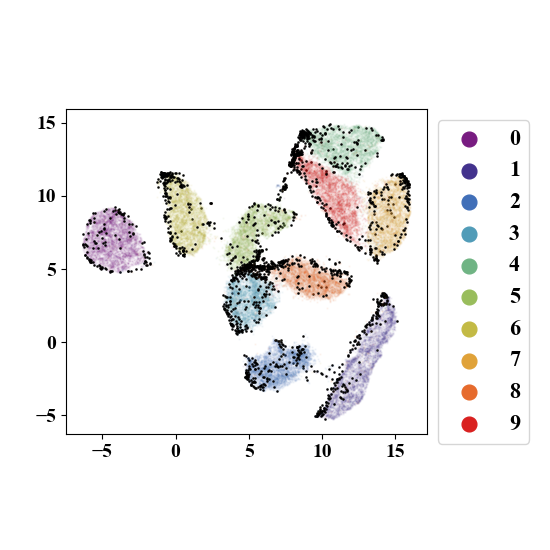

digit: 0 Jaccard index: 0.12866817155756208
digit: 1 Jaccard index: 0.2610340479192938
digit: 2 Jaccard index: 0.19189511323003575
digit: 3 Jaccard index: 0.23915737298636927
digit: 4 Jaccard index: 0.23915737298636927
digit: 5 Jaccard index: 0.2422360248447205
digit: 6 Jaccard index: 0.2755102040816326
digit: 7 Jaccard index: 0.2376237623762376
digit: 8 Jaccard index: 0.3717421124828532
digit: 9 Jaccard index: 0.3812154696132597
Avg Jaccard index: 0.25682396520783335


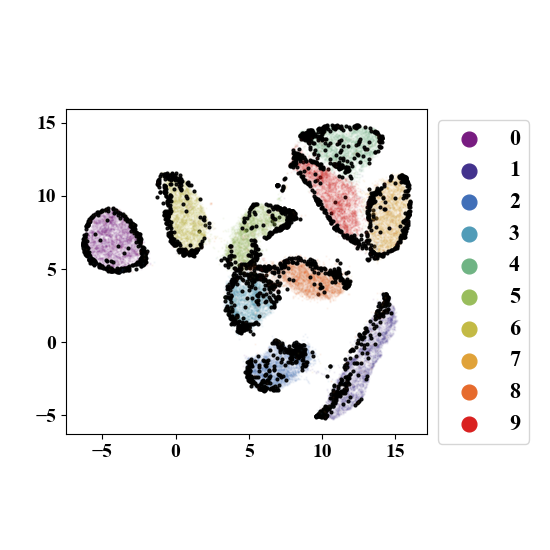

digit: 0 Jaccard index: 0.12866817155756208
digit: 1 Jaccard index: 0.2610340479192938
digit: 2 Jaccard index: 0.19189511323003575
digit: 3 Jaccard index: 0.23915737298636927
digit: 4 Jaccard index: 0.23915737298636927
digit: 5 Jaccard index: 0.2422360248447205
digit: 6 Jaccard index: 0.2755102040816326
digit: 7 Jaccard index: 0.2376237623762376
digit: 8 Jaccard index: 0.3717421124828532
digit: 9 Jaccard index: 0.3812154696132597
Avg Jaccard index: 0.25682396520783335


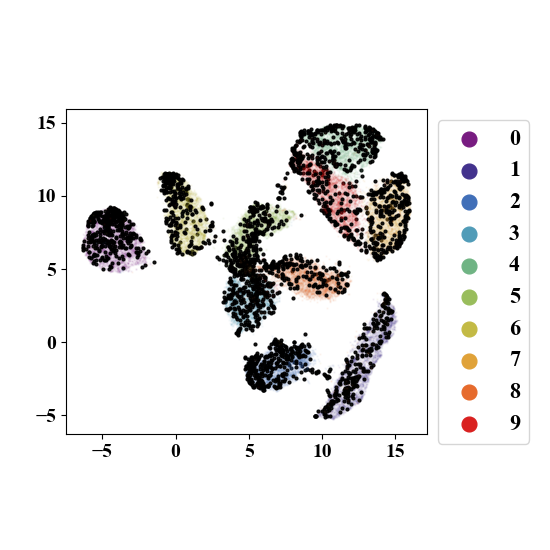

In [192]:
compare_bdry_diff(bx_ds_lpca_per_digit, bx_ds_per_digit, 10, s=3, plot=1, figsize=(5.5,5.5), save_fn='DS_LPCA_cap_DS')
compare_bdry_diff(bx_ds_lpca_per_digit, bx_ds_per_digit, 10, s=8, plot=2, figsize=(5.5,5.5), save_fn='DS_LCPA_minus_DS')
compare_bdry_diff(bx_ds_lpca_per_digit, bx_ds_per_digit, 10, s=8, plot=3, figsize=(5.5,5.5), save_fn='DS_minus_DS_LPCA')

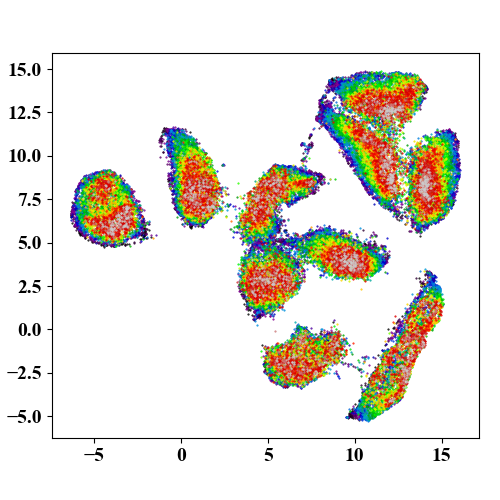

In [179]:
plot_bx_percentile_wise(bx_ds_lpca_per_digit, dprctile=2, s=1)

In [181]:
n_samples_per_digit = 15
prctile = 5
fig_h = 0.5
cmap = 'gray'

In [184]:
def get_exemplars_of_single_digit(bx):
    mask1 = bx < np.percentile(bx, prctile)
    pts_on_bdry = np.where(mask1)[0]
    mask2 = bx > np.percentile(bx, 100-prctile)
    pts_in_interior = np.where(mask2)[0]
    np.random.seed(42)
    np.random.shuffle(pts_on_bdry)
    np.random.shuffle(pts_in_interior)
    return (pts_on_bdry[:n_samples_per_digit].tolist(),
            pts_in_interior[:n_samples_per_digit].tolist())
    # p1=np.exp(-bx[mask])
    # a = np.max(bx[~mask])
    # p2=np.exp((bx[~mask]-a))
    # pts_on_bdry = np.random.choice(pts_on_bdry, n_samples_per_digit, p=p1/np.sum(p1))
    # pts_in_interior = np.random.choice(pts_in_interior, n_samples_per_digit, p=p2/np.sum(p2))
    # return (pts_on_bdry.tolist(), pts_in_interior.tolist())
    

def plot_exemplars(bx_per_digit, save_fn=None):
    n_digits = len(digits)
    fig1, axs1 = plt.subplots(n_digits, n_samples_per_digit+1, figsize=(fig_h+n_samples_per_digit*fig_h,n_digits*fig_h))
    fig1.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0, hspace=0)
    fig2, axs2 = plt.subplots(n_digits, n_samples_per_digit+1, figsize=(fig_h+n_samples_per_digit*fig_h,n_digits*fig_h))
    fig2.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0, hspace=0)
    for i in range(len(digits)):
        mask = labels == i
        bdry_pts, interior_pts = get_exemplars_of_single_digit(bx_per_digit[i])
        for j in range(len(bdry_pts)):
            axs1[i,j].imshow(imgs[mask,:][bdry_pts[j],:].reshape(img_shape), cmap=cmap)
            axs1[i,j].set_axis_off()
        for j in range(len(interior_pts)):
            axs2[i,j].imshow(imgs[mask,:][interior_pts[j],:].reshape(img_shape), cmap=cmap)
            axs2[i,j].set_axis_off()

        axs1[i,-1].imshow(np.mean(imgs[mask,:][bdry_pts,:], axis=0).reshape(img_shape), cmap=cmap)
        axs1[i,-1].set_axis_off()
        axs2[i,-1].imshow(np.mean(imgs[mask,:][interior_pts,:], axis=0).reshape(img_shape), cmap=cmap)
        axs2[i,-1].set_axis_off()

    if save_fn:
        fig1.savefig(ex_name + '_' + save_fn + '_bdry.png', dpi=400)
        fig2.savefig(ex_name + '_' + save_fn + '_interior.png', dpi=400)

def plot_exemplars_one_plot(bx_per_digit, save_fn=None):
    n_digits = len(digits)
    fig, axs = plt.subplots(2*n_digits, n_samples_per_digit+1, figsize=(fig_h+n_samples_per_digit*fig_h,2*n_digits*fig_h))
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0, hspace=0)
    for i in range(len(digits)):
        mask = labels == i
        bdry_pts, interior_pts = get_exemplars_of_single_digit(bx_per_digit[i])
        for j in range(len(bdry_pts)):
            axs[2*i,j].imshow(imgs[mask,:][bdry_pts[j],:].reshape(img_shape), cmap=cmap)
            axs[2*i,j].set_axis_off()
        for j in range(len(interior_pts)):
            axs[2*i+1,j].imshow(imgs[mask,:][interior_pts[j],:].reshape(img_shape), cmap=cmap)
            axs[2*i+1,j].set_axis_off()

        axs[2*i,-1].imshow(np.mean(imgs[mask,:][bdry_pts,:], axis=0).reshape(img_shape), cmap=cmap)
        axs[2*i,-1].set_axis_off()
        axs[2*i+1,-1].imshow(np.mean(imgs[mask,:][interior_pts,:], axis=0).reshape(img_shape), cmap=cmap)
        axs[2*i+1,-1].set_axis_off()

    if save_fn:
        fig.savefig(ex_name + '_' + save_fn + '_bdry_interior.png', dpi=400)

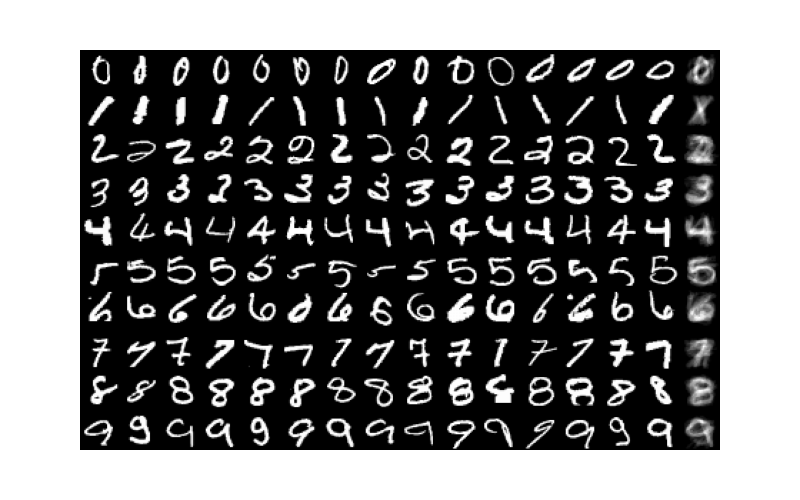

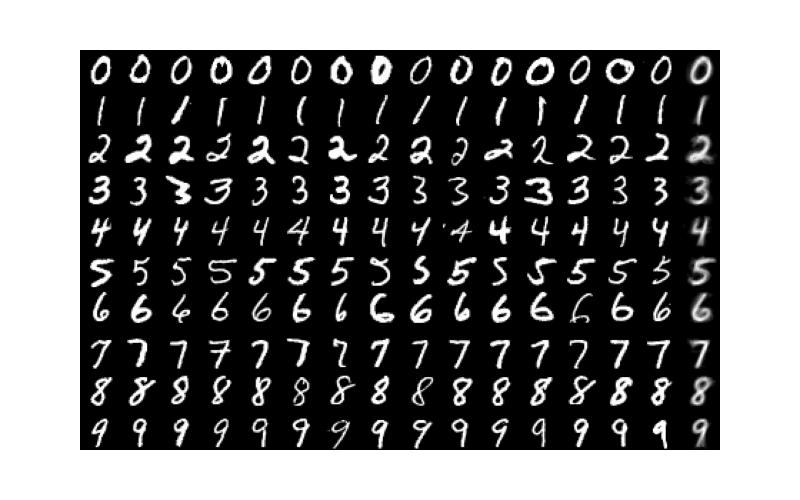

In [185]:
plot_exemplars(bx_ds_lpca_per_digit, save_fn='DS_LPCA_images')